# Mask R-CNN - Train on Solar Dataset


This notebook allows you to train Mask R-CNN on the solar dataset. It requires a GPU for faster processing.

## Imports for Colab

In [0]:
# Make sure the notebook will use tensorflow version 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# Install keras version 2.1.0
!pip install keras==2.1.0

     |████████████████████████████████| 307kB 6.3MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
# Check if GPU is activated (if not, use top menu 'Change execution type')
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# Clone Mask R-CNN repo
!git clone --quiet https://github.com/matterport/Mask_RCNN.git
print("Mask_RCNN successfuly cloned.")

Mask_RCNN successfuly cloned.


In [0]:
# Install dependencies
%cd /content/Mask_RCNN
!pip install -q PyDrive
!pip install -q -r requirements.txt
!python setup.py install
!apt install -q python3-rtree
!pip install -q osmnx
!pip install -q imantics

/content/Mask_RCNN
     |████████████████████████████████| 204kB 8.6MB/s 
     |████████████████████████████████| 163kB 36.8MB/s 
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.l

In [0]:
# Check the correct version of tensorflow (1.x) and keras (2.1) have been loaded
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

1.15.2
2.1.0


Using TensorFlow backend.


In [0]:
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [0]:
# Import solar.py
print("Please upload solar.py to Colab")
from google.colab import files
src = list(files.upload().values())[0]
open('solar.py','wb').write(src)
import solar

Please upload solar.py to Colab


Saving solar.py to solar.py


In [0]:
# Import dataset
# Method 1: use side menu to import from local disk, and then:
!unzip -q /content/solar_mod_stock_ox.zip -d /content/Mask_RCNN
print("Successfuly unzipped dataset.")

In [0]:
# Method 2: to mount dataset solar.zip from Google Drive, use code below
%cd /content/Mask_RCNN

fileId = '10-i2IcRjt7BwAfyNVgkZHX-V6xVgRnvT'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

if not os.path.exists('dataset'):
  os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/content/Mask_RCNN
Extracted zip file 10-i2IcRjt7BwAfyNVgkZHX-V6xVgRnvT.zip


In [0]:
# Other required imports
import random
import re
import time
import cv2
import os
import sys
import numpy as np
import skimage
import urllib
import json
import osmnx as ox
import shapely
import pyproj
import imantics
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [0]:
# Root directory of the project
ROOT_DIR = "/content/Mask_RCNN"

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
if not os.path.exists(LOGS_DIR):
  os.makedirs('/content/Mask_RCNN/logs')

# Local path to dataset
IMAGES_DIR = os.path.join(ROOT_DIR, "dataset/data/images")
MASKS_DIR = os.path.join(ROOT_DIR, "dataset/data/masks")

# Local path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_WEIGHTS_PATH):
#    utils.download_trained_weights(COCO_WEIGHTS_PATH)

In [15]:
# Upload last trained weights

%cd /content/Mask_RCNN/logs

fileId = '1tpFs1hFJIKjjQ30MJQQrfjTIBNU5X38x'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/content/Mask_RCNN/logs
Extracted zip file 1tpFs1hFJIKjjQ30MJQQrfjTIBNU5X38x.zip


## Configurations

Model configurations are defined in `solar.py`.

In [16]:
config = solar.SolarConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [17]:
class CustomConfig(solar.SolarConfig):
  IMAGES_PER_GPU = 1

config = CustomConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Dataset

Load the train and val datasets and display samples.

In [18]:
# Training dataset
dataset_train = solar.SolarDataset()
dataset_train.load_solar(IMAGES_DIR, train_test_split=0.8, is_train=True)
dataset_train.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
print("\n")

# Validation dataset
dataset_val = solar.SolarDataset()
dataset_val.load_solar(IMAGES_DIR, train_test_split=0.8, is_val=True)
dataset_val.prepare()

print("\nImage Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Split ratio = 80%
Nb of training images = 1748
Image Count: 1748
Class Count: 2
  0. BG                                                
  1. solar array                                       


Split ratio = 9%
Nb of validation images = 219

Image Count: 219
Class Count: 2
  0. BG                                                
  1. solar array                                       


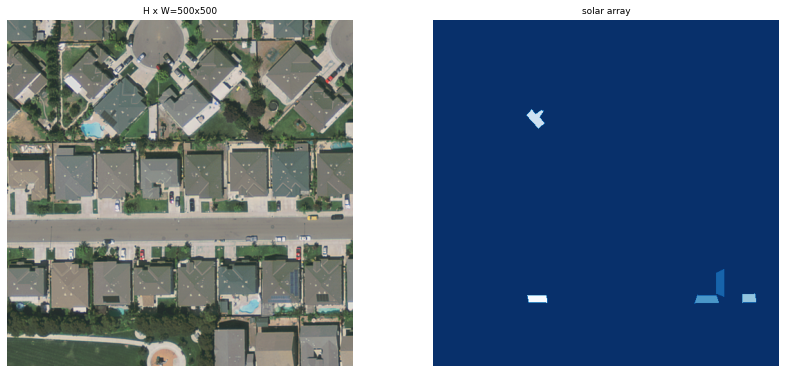

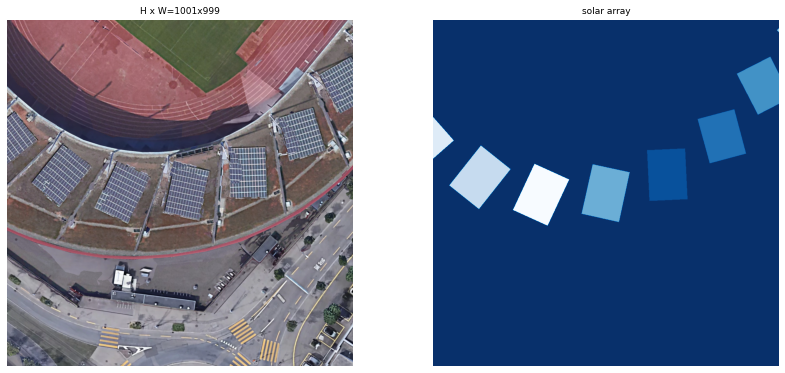

In [19]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

## Create Model

In [20]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=LOGS_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Note that if we want to include the relative luminance channel in training, we can't use the pre-trained weights for the first layer of the model, as it will receive a different input shape. Therefore we need to add `conv1` to the `exclude` parameter in the `model.load_weights` method (then, the rest of the model will adapt). See below:

In [22]:
# Load selected weights
init_with = "best"
rel_lum = False

if init_with == "imagenet":
    if rel_lum:
      model.load_weights(model.get_imagenet_weights(), by_name=True,
                         exclude=["conv1"])
    else:
      model.load_weights(model.get_imagenet_weights(), by_name=True)
    print("Loaded model: ImageNet pre-trained weights")

elif init_with == "coco":
    # Remark: we skip layers that are different due to different nb of classes
    if rel_lum:
      model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                        exclude=["conv1", "mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    else:
      model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    print("Loaded model: COCO pre-trained weights")

elif init_with == "last":
    if not rel_lum:
      # 1st option: load the last trained model and continue training
      model.load_weights(model.find_last(), by_name=True)
      # 2nd option: load a specific .h5 file
      #model.load_weights(os.path.join(ROOT_DIR, ".h5 file"), by_name=True)
    else:
      model.load_weights(model.find_last(), by_name=True, exclude=["conv1"])
    print("Loaded model: ", model.find_last())

elif init_with == "best":
    best_model = '/content/Mask_RCNN/logs/logsmy_checkpoint_first_step.h5'
    # Load the last model you trained and continue training
    model.load_weights(best_model, by_name=True)
    print("loaded best model : ", best_model)







loaded best model :  /content/Mask_RCNN/logs/logsmy_checkpoint_first_step.h5


## Training

Several training routines are possible:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that do not use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `model.train()` function.

2. Fine tune the superior layers (i.e. the most "customized") with `layers_to_train = "3+"` or `"4+"`.

3. Fine-tune all layers. For this use case it's not necessary, but we could simply set `layers_to_train = "all"`, which passes `layers="all` to the `model.train()` function.

Note that if we include the rel_lum layer in training, we need to add `conv1` (the first layer, initialized with random weights to match a 4-dimensional input shape) to `layers_to_train`.

Below, we apply the in 3 training steps successively.

In [0]:
# Choose training routine
# step = "first"
step = "second"
# step = "last"

In [0]:
# Custom callbacks: early stopping and model saving
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=4)
modelCheckpoint = ModelCheckpoint(os.path.join(LOGS_DIR, "my_checkpoint_{}_step.h5".format(step)),
                                  save_best_only = True, save_weights_only=True)
my_callbacks = [modelCheckpoint, monitor_val_loss]

# Custom augmentations
augments = iaa.SomeOf((1, None), # apply one to all of the listed augmenters, in random order
           [iaa.Fliplr(0.5), iaa.Flipud(0.5)], random_order=True)
# augments = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.5)], random_order=True)
# augmentats = iaa.SomeOf((0, 2), [
#     iaa.Fliplr(0.5), iaa.Flipud(0.5),
#     iaa.OneOf([iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270)]),
#     iaa.Multiply((0.8, 1.2)),
#     iaa.GaussianBlur(sigma=(0.0, 1.0))])

# Learning rate
lr = config.LEARNING_RATE

In [0]:
# Train selected layers/branches

if step == "first":
    # Training - Stage 1
    # Adjust epochs and layers as needed
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                custom_callbacks=my_callbacks,
                augmentation=augments,
                epochs=20,
                layers='heads')
    # When training with 4+ channels, use instead of 'heads':
    # r"conv1|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)"

if step == "second":
    # Training - Stage 2
    # Finetune layers from ResNet stage 3 and up
    print("Training ResNet layers 3+")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/5,
                custom_callbacks=my_callbacks,
                augmentation=augments,
                epochs=40,
                layers='3+')

if step == "last":
    # Fine-tune all layers
    print("Training all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/25,
                custom_callbacks=my_callbacks,
                augmentation=augments,
                epochs=80,
                layers='all')

Training ResNet layers 3+

Starting at epoch 0. LR=0.0002

Checkpoint Path: /content/Mask_RCNN/logs/solar20200525T2129/mask_rcnn_solar_{epoch:04d}.h5
Selecting layers to train
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
bn3a_branch2c          (BatchNorm)
bn3a_branch1           (BatchNorm)
res3b_branch2a         (Conv2D)
bn3b_branch2a          (BatchNorm)
res3b_branch2b         (Conv2D)
bn3b_branch2b          (BatchNorm)
res3b_branch2c         (Conv2D)
bn3b_branch2c          (BatchNorm)
res3c_branch2a         (Conv2D)
bn3c_branch2a          (BatchNorm)
res3c_branch2b         (Conv2D)
bn3c_branch2b          (BatchNorm)
res3c_branch2c         (Conv2D)
bn3c_branch2c          (BatchNorm)
res3d_branch2a         (Conv2D)
bn3d_branch2a          (BatchNorm)
res3d_branch2b         (Conv2D)
bn3d_branch2b          (BatchNorm)
res3d_branch2c      

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/40
 432/1748 [======>.......................] - ETA: 9:30 - loss: 1.0212 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1963 - mrcnn_mask_loss: 0.2758

In [0]:
# Open tensorboard for visualizations
%load_ext tensorboard
%tensorboard --logdir /content/Mask_RCNN/logs/solar20200519T1110

## Detection test

In [0]:
class InferenceConfig(solar.SolarConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [0]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=LOGS_DIR)

# Load trained weights (either last model or .h5 file path)
model_path = model.find_last()
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model.load_weights(model_path, by_name=True)
print("Loaded model:", model_path)

In [0]:
# Pick random image in validation set
test_id = np.random.choice(dataset_val.image_ids)
print("Image id :", test_id)
info = dataset_val.image_info[test_id]
# print("Image name :", info["img_name"])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    dataset_val, inference_config, test_id, use_mini_mask=False)

Image id : 360


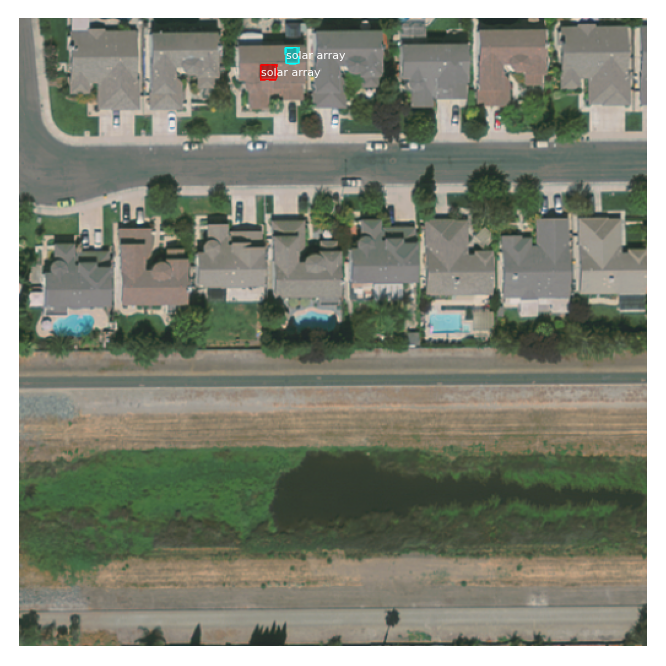

In [0]:
# Visualize ground truth
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(12, 12))

In [0]:
# Run detection
yhat = model.detect([original_image], verbose=1)[0] # verbose=0
n_solar = yhat['masks'].shape[2]
print("Nb of solar arrays detected: ", n_solar)

Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  245.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.21000  max:  131.79000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Nb of solar arrays detected:  2


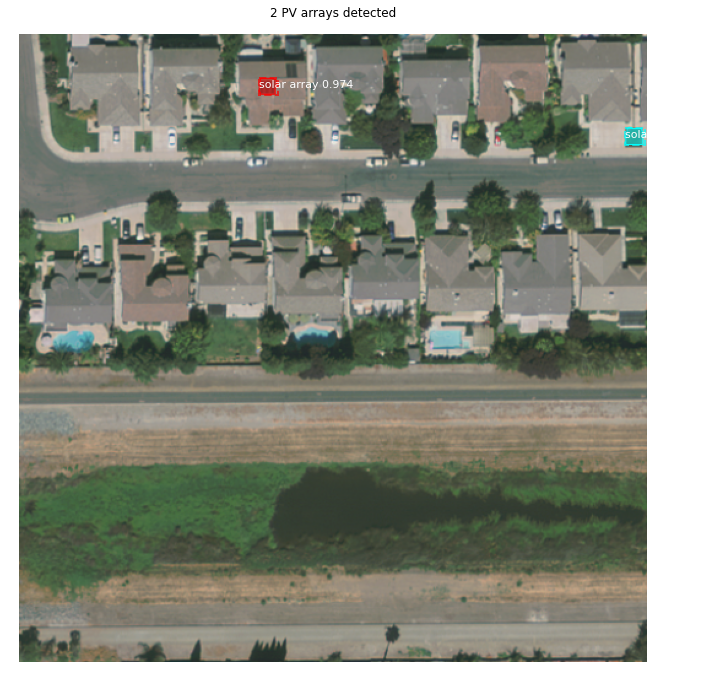

In [0]:
# Display
visualize.display_instances(original_image, yhat['rois'], yhat['masks'],
                            yhat['class_ids'], dataset_val.class_names,
                            yhat['scores'], figsize=(12, 12),
                            title="{} PV arrays detected".format(n_solar))

In [0]:
# Compute surface over detected masks
pv_surface = solar.compute_mask_to_surface(yhat['masks'])

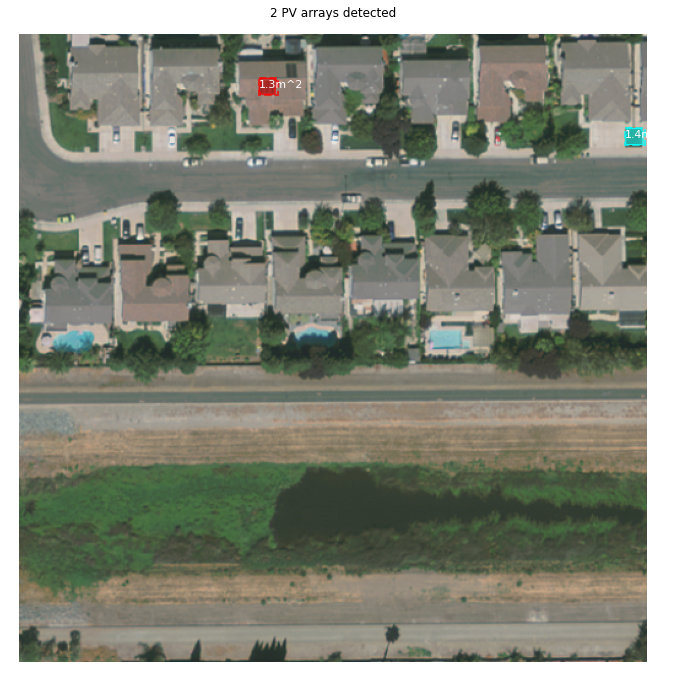

In [0]:
# Display prediction, with surface annotation
pv_size_annot = [str(round(x,1))+"m^2" for x in pv_surface]
visualize.display_instances(original_image, yhat['rois'], yhat['masks'],
                            yhat['class_ids'], dataset_val.class_names,
                            captions=pv_size_annot, 
                            title="{} PV arrays detected".format(n_solar),
                            figsize=(12, 12))

## Quick evaluation

In [0]:
# Load test dataset
dataset_test = solar.SolarDataset()
dataset_test.load_solar(IMAGES_DIR, train_test_split=0.8, is_test=True)
dataset_test.prepare()

print("\nImage Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
    print("{:3}. {:50}".format(i, info['name']))

In [0]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 100 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.18801666676998138
